In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from seaborn import *
import findspark
findspark.init()
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
import re

import warnings
warnings.filterwarnings('ignore')

# Sugar is linked to health issues, but so are fats and salts. Do sugary products also tend to contain more fat/salt or not?

* Grab all products sugar and fat and salt
* Analyse correlation.
* Break down into categories?

In [2]:
#Load the data
df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("delimiter", "\t")\
    .load('./data/en.openfoodfacts.org.products.csv')

In [4]:
#Allow SQL queries to be executed
df.createOrReplaceTempView("df_view")

#Obtain all products that has a list of categories defined
sqlDF = spark.sql("SELECT product_name, sugars_100g, fat_100g, salt_100g, energy_100g, serving_quantity \
                  FROM df_view \
                  WHERE \
                  sugars_100g IS NOT NULL AND sugars_100g <= 100 AND sugars_100g >= 0 AND \
                  fat_100g IS NOT NULL    AND fat_100g <= 100    AND fat_100g >= 0 AND \
                  salt_100g IS NOT NULL   AND salt_100g <= 100   AND salt_100g >= 0")

In [5]:
#Convert it into a dataframe
data = sqlDF.toPandas()

#Correct the Dtypes
data['sugars_100g'] = data['sugars_100g'].astype(float)
data['fat_100g'] = data['fat_100g'].astype(float)
data['salt_100g'] = data['salt_100g'].astype(float)

In [190]:
#Select what information to have a look at
nutrition = data[['sugars_100g', 'fat_100g', 'salt_100g']]

#Limit amount of data for the sake of testing
#nutrition = nutrition.head(3000)

Restricting the amounts to valid ranges reduced the amount of objects from 560974 to 560447, so around one in a thousand items are wrongly labeled.

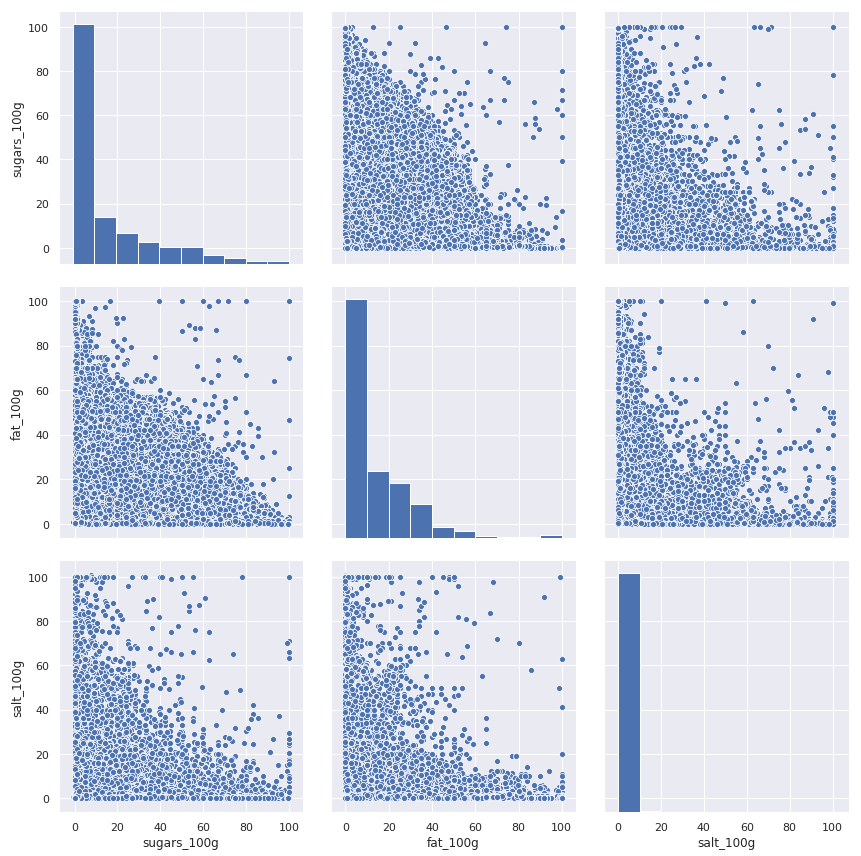

In [13]:
sns.pairplot(data=nutrition, size = 4)
plt.show()

Looking at the pairplot just to get a quick overview, it seems that the distribution of values heavily leans towards zero for all three variables, especially salt. Given the large amount of datapoints however, it is difficult to tell. Let's plot the density instead.

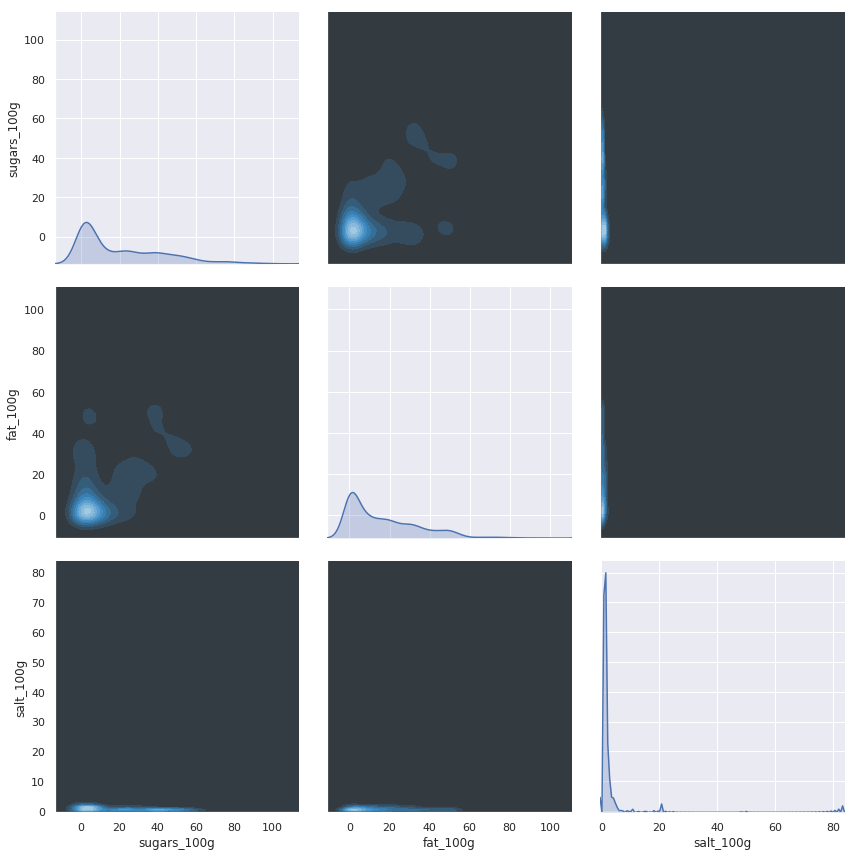

In [183]:
g = sns.PairGrid(nutrition, size = 4)
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(sns.kdeplot, n_levels=10, cmap="Blues_d", shade=True);

Better, but still a bit too dense. Let's remove values beyond two stds to better represent the common case

removed 295 products


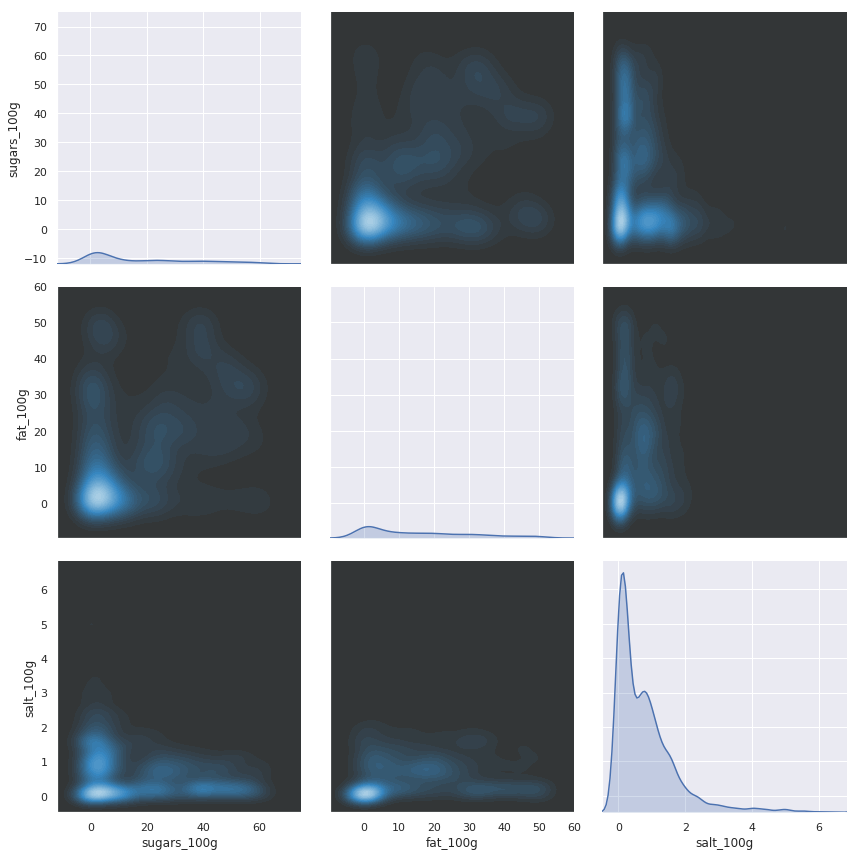

In [184]:
reduced = nutrition[np.abs(nutrition-nutrition.mean()) <= (2*nutrition.std())].dropna()
print("removed {} products".format(nutrition.shape[0] - reduced.shape[0]))

g = sns.PairGrid(reduced, size = 4)
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(sns.kdeplot, n_levels=30, cmap="Blues_d", shade=True);

Looks like it at the very least isn't just random noise. Let's try to calculate the correlation coefficient

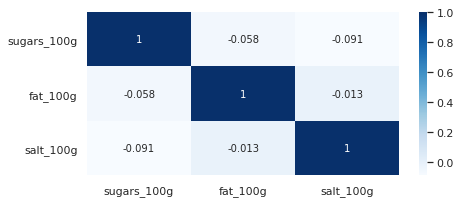

In [194]:
plt.figure(figsize=(7,3))
sns.heatmap(nutrition.corr(method='pearson'), annot=True, cmap = 'Blues')

The Pearson coefficient is sensitive for outliers and measures the linear relationship between the variables. 1=Perfect positive relationship, -1 = perfect negative relationship, 0 = no relationship.

Using all data it doesn't look like there is any correlation, but since Pearson IS weak to outliers, let's also use the reduced data

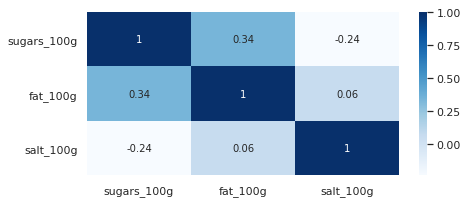

In [195]:
plt.figure(figsize=(7,3))
sns.heatmap(reduced.corr(method='pearson'), annot=True, cmap = 'Blues')

Looking at the values there is no strong linear relationship between any variables. Sugar and salt seem have a slight tendency to not go together, while both salt and fat and sugar and fat as weak positive relationships.

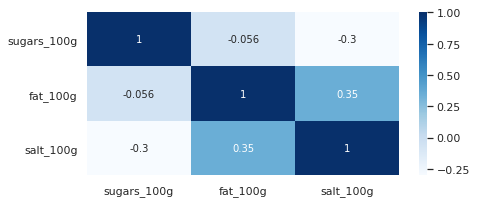

In [196]:
plt.figure(figsize=(7,3))
sns.heatmap(nutrition.corr(method='spearman'), annot=True, cmap = 'Blues')

The spearman coefficient only cares about monotonicity. It asks the question:
Even if the relationship isn't linear, does the increase/decrease in one variable correspond to an increase/decrease in the other.
Looking at the values, we observe that fat and sugar seem to be nearly completely independent.
There is a weak negative correlation between salt and sugar, increasing one thhus has a slight tendency to imply a decrease in another.
The strongest relationship observed is the positive one between salt and fat.


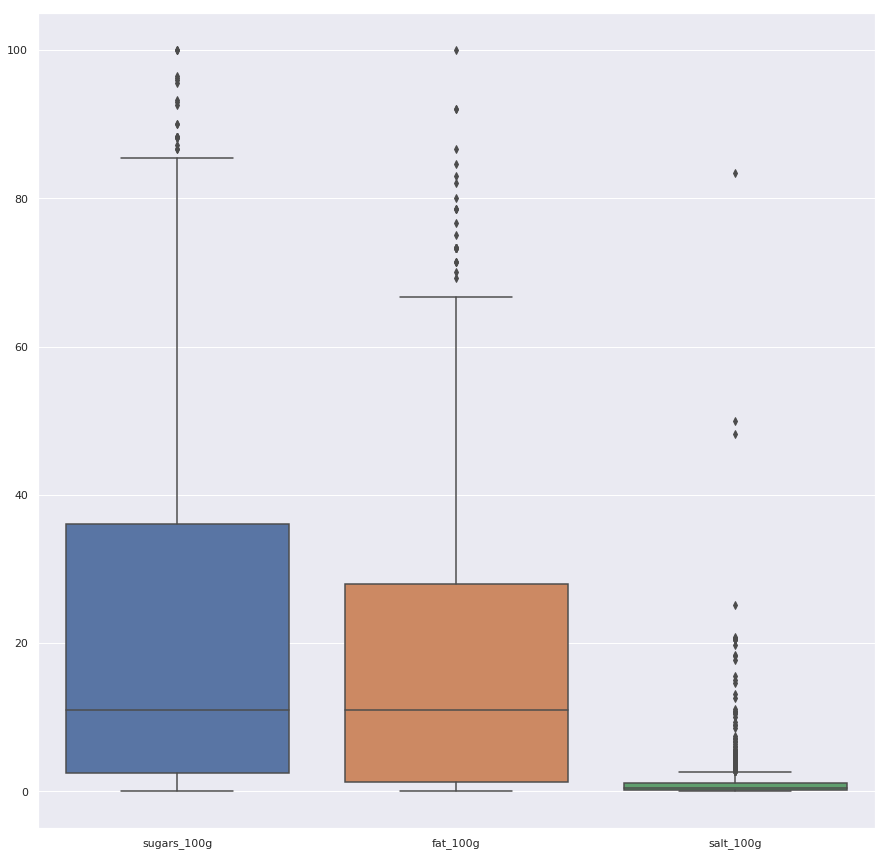

In [188]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15) )
sns.boxplot(data = nutrition)
plt.show()

For both salt and fat 75 percent of all products have less than 20grams of the respective product, while salt content is close to zero for all products. To get some insight into if salt is associated with more sugary/fat products, we create a scatterplot and color it by salt.

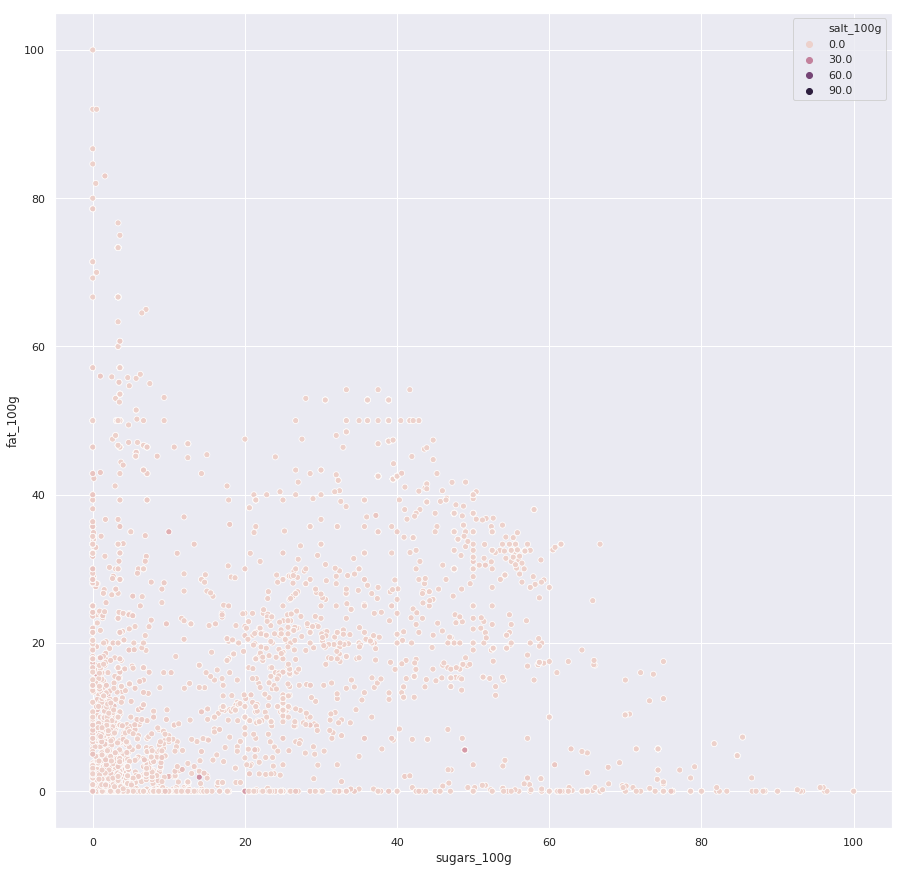

In [189]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15) )
sns.scatterplot(x="sugars_100g", y="fat_100g",hue='salt_100g', data=nutrition)

Visually, it looks like there is no correlation. Given the risk of overlap with this many datapoints, let's have a look at a density plot as well.

# It is often said that cheap and sugary go hand in hand. Is there any correlation between sugar content in low-price brands and high price brands?
* Identify low-cost brands and "high price" (normal?) brands
* Seperate them. Ensure no overlap.
* Analyse correlation

In [7]:
#Allow SQL queries to be executed
df.createOrReplaceTempView("df_view")

#Obtain all products that has a list of categories defined
sqlDF = spark.sql("SELECT product_name, brands_tags, sugars_100g \
                  FROM df_view \
                  WHERE brands_tags IS NOT NULL AND\
                  sugars_100g >= 0 AND sugars_100g <=100")

#Convert it into a dataframe
brands_df = sqlDF.toPandas()
brands_df['sugars_100g'] = brands_df['sugars_100g'].astype(float)

In [63]:
#The brands are formatted as a single string, so we define a function to explode the content.
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df


brands = splitDataFrameList(brands_df, 'brands_tags', ',')

In [152]:
#To compare the sugar content across different types of brands, we select five brands capable of representing each sub category
#Each product line was manually checked to ensure it really belonged to the right category
categories = pd.read_csv('./brands.csv')

low = brands[brands['brands_tags'].isin(categories.low)]
high = brands[brands['brands_tags'].isin(categories.high)]
bio = brands[brands['brands_tags'].isin(categories.bio)]
norm = brands[brands['brands_tags'].isin(categories.norm)]

l = low[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
h = high[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
b = bio[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
n = norm[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()

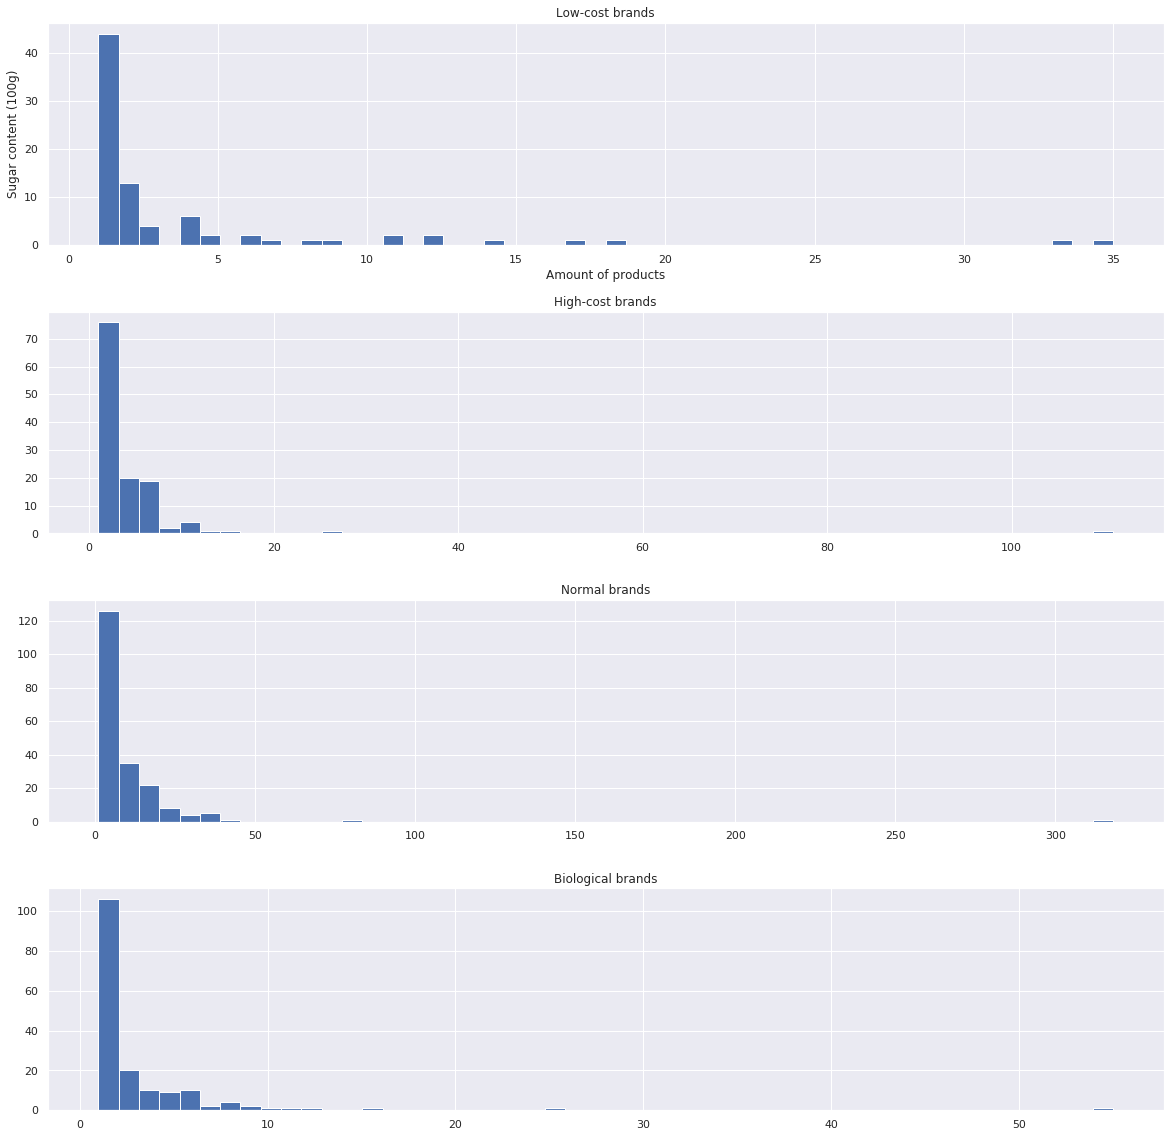

In [180]:
#Plot the distributions
fig, axs = plt.subplots(4, 1, figsize=(20, 20) )

l.hist(ax=axs[0], bins=50)
axs[0].set_title('Low-cost brands')
axs[0].set_ylabel("Sugar content (100g)")
axs[0].set_xlabel("Amount of products")

h.hist(ax=axs[1], bins=50)
axs[1].set_title('High-cost brands')

n.hist(ax=axs[2], bins=50)
axs[2].set_title('Normal brands')

b.hist(ax=axs[3], bins=50)
axs[3].set_title('Biological brands')
plt.show()
